In [1]:
import numpy as np
import pickle
import time 
import timeit
import shutil 
import h5py
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from functools import partial
import glob
import os
import pandas as pd
import statistics as sta
from scipy.stats import circstd, circmean
from scipy.signal import savgol_filter
import ruptures as rpt
import seaborn as sns

In [3]:
pol1_full = np.load("/home/lars/vmodel_output/relax_v5_Nocol_vor_pol_fangle_pangle.npy")
pol2_full = np.load("/home/lars/vmodel_output/relax_noPred_NoCol_vor_pol_fangle_pangle.npy")

In [4]:
rel_time_hm = np.zeros((1,3,100))
nruns = 100
time = len(pol1_full[0,0,0,:])
method="bs"



for ii in range(1):
    for jj in range(3):
    
        
        pol = pol1_full[ii,jj,:,:]
        pol2 = pol2_full[0,0,:,:]
    ################################################################################
        ################## THE IMPORTANT STUFF STARTS BELOW ############################
        ################################################################################

        ## ALL THE CODE BELOW - COMPUTES THE RELAXATION TIME ###
        mean_pol0=np.transpose(pol2).mean(axis=1)
        mean_pol1=[np.mean(mean_pol0)]*time
        flat_list = [item for sublist in pol2 for item in sublist]
        std_pol1=np.std(flat_list)
    
        for k in range(nruns):
           # t_end_fnt=[index for index,value in enumerate(FNT[k]) if value == 1][-1]
            points=pol[k]         
            if method=="dp":
                #Changepoint detection with dynamic programming search method
                model = "l1"  
                algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
            elif method=="bs":
                #Changepoint detection with the Binary Segmentation search method
                model = "l2"  
                algo = rpt.Binseg(model=model).fit(points)
            my_bkps = algo.predict(n_bkps=10)
          #  relax_t[k] = my_bkps[-2]-t_end_fnt  #### <----- WE DO NOT DO IT SINCE IT CAN INCREASE THE VARIATION IN THE VALUES, WE WANT TO KEEP IT CLEAN
           
           #### Lower Control Limits
            yhat2 = savgol_filter(mean_pol1-3*std_pol1-points, 333, 2)
            l2=np.where(yhat2 <0)[0]
            if len(np.array(l2))>0:
                i=1
                while (l2[i]-l2[i-1]==1) and (i<len(np.array(l2))-1):
                      i=i+1
            else:
                i=0

            if i==len(np.array(l2))-1 or i==0:
                rel_time_hm[ii,jj,k]=np.nan # time
            else:
                rel_time_hm[ii,jj,k]=l2[i]



In [5]:

perc_75 = np.nanpercentile(rel_time_hm, 75)

rel_filtered = np.copy(rel_time_hm) #[rel_time_hm >= perc_75]
rel_filtered[rel_filtered >= perc_75] = "NaN"

reltime_mean = np.nanmean(rel_time_hm[:,:,:], axis= 2)



/home/lars/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


5.4957796209676264e-05
5.4957796209676264e-05
1.0
[[(1, 3), 5.4957796209676264e-05], [(1, 2), 5.4957796209676264e-05]]


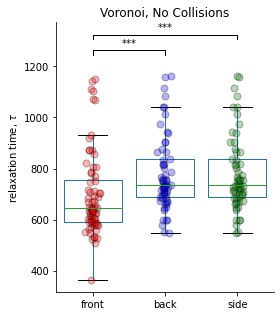

In [6]:
front_rel_set = rel_filtered[0,0]
side_rel_set = rel_filtered[0,1]
back_rel_set = rel_filtered[0,2]

df= pd.DataFrame(rel_filtered[0])

df = pd.DataFrame({'front': front_rel_set,

                   'back': back_rel_set,

                   'side': side_rel_set})

front_rel_set = front_rel_set[~np.isnan(front_rel_set)]
front_rel_set = front_rel_set[front_rel_set<perc_75]

back_rel_set = back_rel_set[~np.isnan(back_rel_set)]
back_rel_set = back_rel_set[back_rel_set<perc_75]

side_rel_set = side_rel_set[~np.isnan(side_rel_set)]
side_rel_set = side_rel_set[side_rel_set<perc_75]

rel_cut = (front_rel_set,back_rel_set, side_rel_set)

data = np.transpose(rel_cut)

from scipy import stats

# Initialise a list of combinations of groups that are significantly different
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = data[combination[0] - 1]
    data2 = data[combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    print(p)
    if p < 0.05:
        significant_combinations.append([combination, p])

print(significant_combinations)




ax = plt.axes()


bp = df.boxplot(grid=False, showfliers=False, widths = 0.8)
#ax.set_aspect(0.003)



for i,d in enumerate(df):
    y = df[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["red","blue","green"][i], mec='k', ms=7, marker="o", linestyle="None",alpha=0.3)
    
    
# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom



# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4,4.5)

plt.ylabel(r'relaxation time, $\tau$')
bp.spines[['right', 'top']].set_visible(False)
plt.title("Voronoi, No Collisions")
plt.tight_layout()
plt.savefig("vor_NoCol_v5.jpg", dpi=400)

[[(1, 3), 1.2149495179542671e-05], [(1, 2), 1.1686931854719306e-27], [(2, 3), 7.481354005904125e-21]]


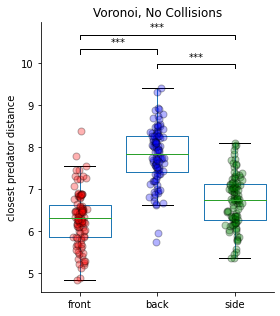

In [8]:
mpd_full = np.load("/home/lars/vmodel_output/relax_v5_Nocol_vor_MPD_fangle_pangle.npy")

front_rel_set = mpd_full[0]
side_rel_set = mpd_full[1]
back_rel_set = mpd_full[2]

perc_75_f = np.nanpercentile(front_rel_set, 75)
perc_75_b = np.nanpercentile(back_rel_set, 75)
perc_75_s = np.nanpercentile(side_rel_set, 75)

#df= pd.DataFrame(mpd_full)



front_rel_set = front_rel_set[~np.isnan(front_rel_set)]
#front_rel_set[front_rel_set>perc_75_f] =  "NaN"


back_rel_set = back_rel_set[~np.isnan(back_rel_set)]
#back_rel_set[back_rel_set>perc_75_b]= "NaN"


side_rel_set = side_rel_set[~np.isnan(side_rel_set)]
#side_rel_set[side_rel_set>perc_75_s]= "NaN"

df = pd.DataFrame({'front': front_rel_set,

                   'back': back_rel_set,

                   'side': side_rel_set})

rel_cut = (front_rel_set,back_rel_set, side_rel_set)

data = rel_cut

from scipy import stats

# Initialise a list of combinations of groups that are significantly different
significant_combinations = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(data) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = data[combination[0] - 1]
    data2 = data[combination[1] - 1]
    # Significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    #print(p)
    if p < 0.05:
        significant_combinations.append([combination, p])

print(significant_combinations)




ax = plt.axes()


bp = df.boxplot(grid=False, showfliers=False, widths = 0.8)
#ax.set_aspect(0.003)




for i,d in enumerate(df):
    y = df[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["red","blue","green"][i], mec='k', ms=7, marker="o", linestyle="None",alpha=0.3)
    

    
    
# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom



# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')
    

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4,4.5)
    
    
plt.ylabel(r'closest predator distance')
bp.spines[['right', 'top']].set_visible(False)
plt.title("Voronoi, No Collisions")
plt.tight_layout()
plt.savefig("vor_NoCol_cpd.jpg", dpi=400)